In [1]:
import pandas as pd
import numpy as np 
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Bidirectional
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential

C:\Users\DELL\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df = pd.read_csv('./MarketPricePrediction.csv')
df['date'] = pd.to_datetime(df['year'].astype(str) + '-' + df['month'], format='%Y-%B')
df = df.sort_values('date').reset_index()

In [3]:
df.drop(['month', 'year','city','state','index'], axis=1, inplace=True)

df

,market,quantity,priceMin,priceMax,priceMod,date
0,LASALGAON(MS),225063,160,257,226,1996-01-01
1,LASALGAON(MS),196164,133,229,186,1996-02-01
2,LASALGAON(MS),178992,155,274,243,1996-03-01
3,LASALGAON(MS),192592,136,279,254,1996-04-01
4,LASALGAON(MS),237574,154,312,269,1996-05-01
...,...,...,...,...,...,...
10222,RAIPUR(CHGARH),4300,950,1142,1077,2016-02-01
10223,INDORE(MP),97178,104,856,575,2016-02-01
10224,YEOLA(MS),272527,347,984,730,2016-02-01
10225,SATANA(MS),90142,281,1130,806,2016-02-01


In [4]:
df.isnull().sum()

market      0
quantity    0
priceMin    0
priceMax    0
priceMod    0
date        0
dtype: int64

In [5]:
df.describe()

,quantity,priceMin,priceMax,priceMod
count,1.022700e+04,10227.000000,10227.000000,10227.000000
mean,7.660488e+04,646.944363,1212.760731,984.284345
std,1.244087e+05,673.121850,979.658874,818.471498
min,2.000000e+01,16.000000,145.000000,80.000000
25%,8.898000e+03,209.000000,557.000000,448.000000
50%,2.746000e+04,440.000000,923.000000,747.000000
75%,8.835650e+04,828.000000,1527.000000,1248.000000
max,1.639032e+06,6000.000000,8192.000000,6400.000000


In [6]:
df.corr()

,quantity,priceMin,priceMax,priceMod
quantity,1.000000,-0.106708,-0.022406,-0.056827
priceMin,-0.106708,1.000000,0.781736,0.883396
priceMax,-0.022406,0.781736,1.000000,0.968069
priceMod,-0.056827,0.883396,0.968069,1.000000


# VISUALIZATION

In [7]:
df['year'] = df['date'].dt.year  # Extract year for grouping
year = df.groupby('year')[['priceMin', 'priceMax', 'priceMod']].mean()
year

,priceMin,priceMax,priceMod
year,,,
1996,161.750000,369.166667,318.583333
1997,119.371429,424.342857,337.914286
1998,533.000000,1180.584906,977.339623
1999,237.685484,476.169355,408.145161
2000,156.588710,351.774194,286.612903
2001,222.230159,474.238095,401.920635
2002,171.480469,439.417969,338.125000
2003,244.313793,559.872414,430.568966
2004,309.137143,564.674286,465.215238


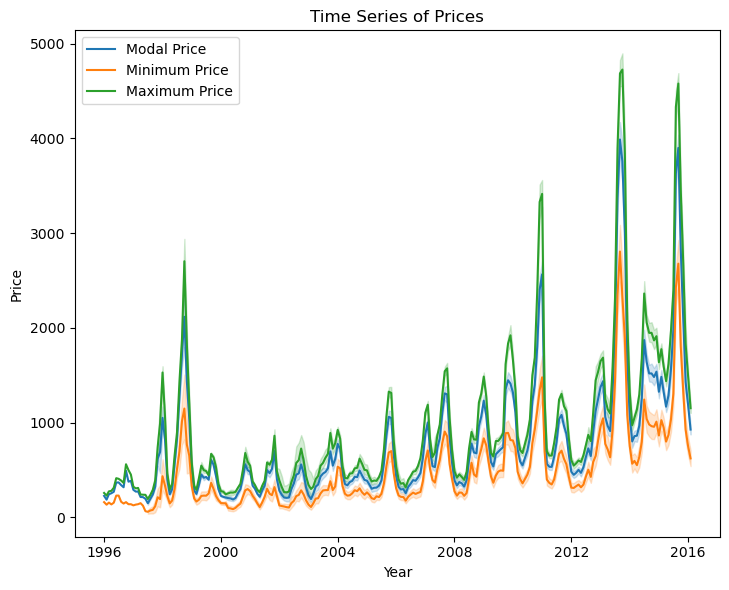

In [8]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 2)
sns.lineplot(data=df, x='date', y='priceMod', label='Modal Price')
sns.lineplot(data=df, x='date', y='priceMin', label='Minimum Price')
sns.lineplot(data=df, x='date', y='priceMax', label='Maximum Price')
plt.title('Time Series of Prices')
plt.xlabel('Year')
plt.ylabel('Price')
plt.legend()

# Adjust layout and show plots
plt.tight_layout()
plt.show()

# SPLIT DATA

In [9]:
encoder = LabelEncoder()

# Apply label encoding to 'market', 'state', and 'city'
df['market_encoded'] = encoder.fit_transform(df['market'])

df

,market,quantity,priceMin,priceMax,priceMod,date,year,market_encoded
0,LASALGAON(MS),225063,160,257,226,1996-01-01,1996,68
1,LASALGAON(MS),196164,133,229,186,1996-02-01,1996,68
2,LASALGAON(MS),178992,155,274,243,1996-03-01,1996,68
3,LASALGAON(MS),192592,136,279,254,1996-04-01,1996,68
4,LASALGAON(MS),237574,154,312,269,1996-05-01,1996,68
...,...,...,...,...,...,...,...,...
10222,RAIPUR(CHGARH),4300,950,1142,1077,2016-02-01,2016,96
10223,INDORE(MP),97178,104,856,575,2016-02-01,2016,49
10224,YEOLA(MS),272527,347,984,730,2016-02-01,2016,119
10225,SATANA(MS),90142,281,1130,806,2016-02-01,2016,104


In [10]:
df.drop(['market'],axis=1,inplace=True)
df['date'] = df['date'].apply(lambda x: x.timestamp())
df = df[['date','market_encoded','priceMin','priceMax','quantity','priceMod']]
df

,date,market_encoded,priceMin,priceMax,quantity,priceMod
0,8.204544e+08,68,160,257,225063,226
1,8.231328e+08,68,133,229,196164,186
2,8.256384e+08,68,155,274,178992,243
3,8.283168e+08,68,136,279,192592,254
4,8.309088e+08,68,154,312,237574,269
...,...,...,...,...,...,...
10222,1.454285e+09,96,950,1142,4300,1077
10223,1.454285e+09,49,104,856,97178,575
10224,1.454285e+09,119,347,984,272527,730
10225,1.454285e+09,104,281,1130,90142,806


In [11]:
split_point = int(len(df) * 0.8)
train_data = df.iloc[:split_point]
test_data = df.iloc[split_point:]

# Display the sizes of the training and test sets
train_data.shape, test_data.shape

((8181, 6), (2046, 6))

In [12]:
X_train= train_data.drop('priceMod',axis=1)
y_train =train_data['priceMod']
X_test= test_data.drop('priceMod',axis=1)
y_test = test_data['priceMod']


# SCALING

In [13]:
print("Shape of X_train before reshaping:", X_train.shape)
print("Shape of X_test before reshaping:", X_test.shape)

# Apply MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape to 3D: samples, timesteps, features
n_timesteps = X_train_scaled.shape[1]
n_features = 1  # Assuming we want to treat each feature as a separate timestep

X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], n_timesteps, n_features))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], n_timesteps, n_features))

print("Shape of X_train after scaling and reshaping to 3D:", X_train_scaled.shape)
print("Shape of X_test after scaling and reshaping to 3D:", X_test_scaled.shape)


Shape of X_train before reshaping: (8181, 5)
Shape of X_test before reshaping: (2046, 5)
Shape of X_train after scaling and reshaping to 3D: (8181, 5, 1)
Shape of X_test after scaling and reshaping to 3D: (2046, 5, 1)


# MODEL

In [18]:
model = Sequential()
model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(64, return_sequences=False)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1))

# Compile the model
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model.compile(optimizer=optimizer, loss='mse')

# Set early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=150, batch_size=64, validation_data=(X_test_scaled, y_test), 
                    verbose=True, callbacks=[early_stopping])



C:\Users\DELL\anaconda3\lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/150
128/128 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step - loss: 1127980.1250 - val_loss: 3562206.7500
Epoch 2/150
128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 1109844.2500 - val_loss: 3450464.2500
Epoch 3/150
128/128 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - loss: 1064170.5000 - val_loss: 3370066.7500
Epoch 4/150
128/128 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - loss: 1090193.0000 - val_loss: 3238583.0000
Epoch 5/150
128/128 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 999517.1250 - val_loss: 3142911.0000
Epoch 6/150
128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 1005599.8750 - val_loss: 3064032.0000
Epoch 7/150
128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 1016436.1250 - val_loss: 2943015.5000
Epoch 8/150
128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 962434.0625 - val_loss: 2594499.2500
Epoch 9/150
128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 933197.5625 - val_loss: 2591243.0000
Epoch 10/150
128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 886635.8750 - val_loss: 2220364.0000
Ep

In [19]:
# Make predictions on the test data
y_pred = model.predict(X_test_scaled)

64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step


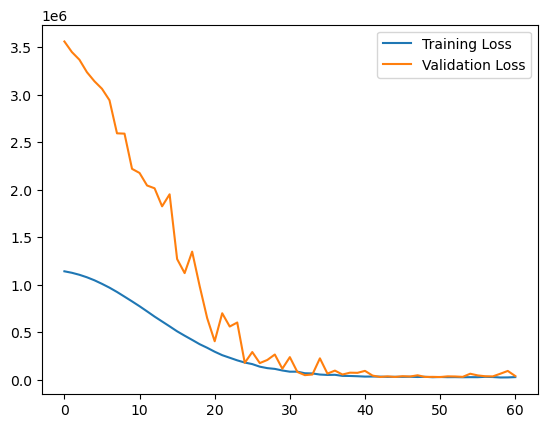

In [22]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# METRICS

In [20]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'r2_score: {r2}')

Mean Squared Error (MSE): 26927.959890170936
Mean Absolute Error (MAE): 103.39133965724375
Root Mean Squared Error (RMSE): 164.09740976069955
r2_score: 0.9674738810568935


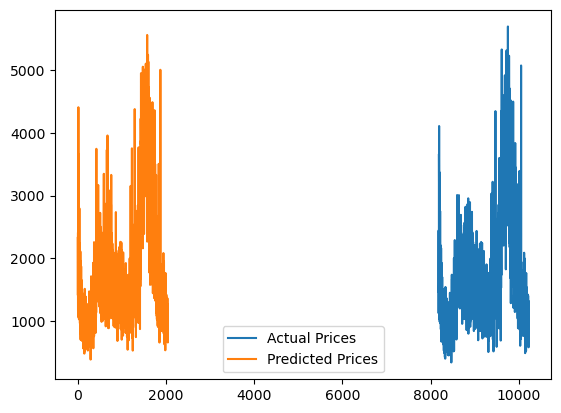

In [21]:
plt.plot(y_test, label='Actual Prices')
plt.plot(y_pred, label='Predicted Prices')
plt.legend()
plt.show()